In [53]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from random import randint

In [54]:
protoFile = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

In [55]:
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


In [71]:
# image1 = cv2.imread(r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\asset\keypoints_detected.JPG")
image1 = cv2.imread(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\pushing.JPG")
print(image1.shape)

frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

(514, 584, 3)


In [72]:
t = time.time()

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

print("Time Taken = {}".format(time.time() - t))


(1, 57, 46, 53)
Time Taken = 3.668264150619507


(-0.5, 583.5, 513.5, -0.5)

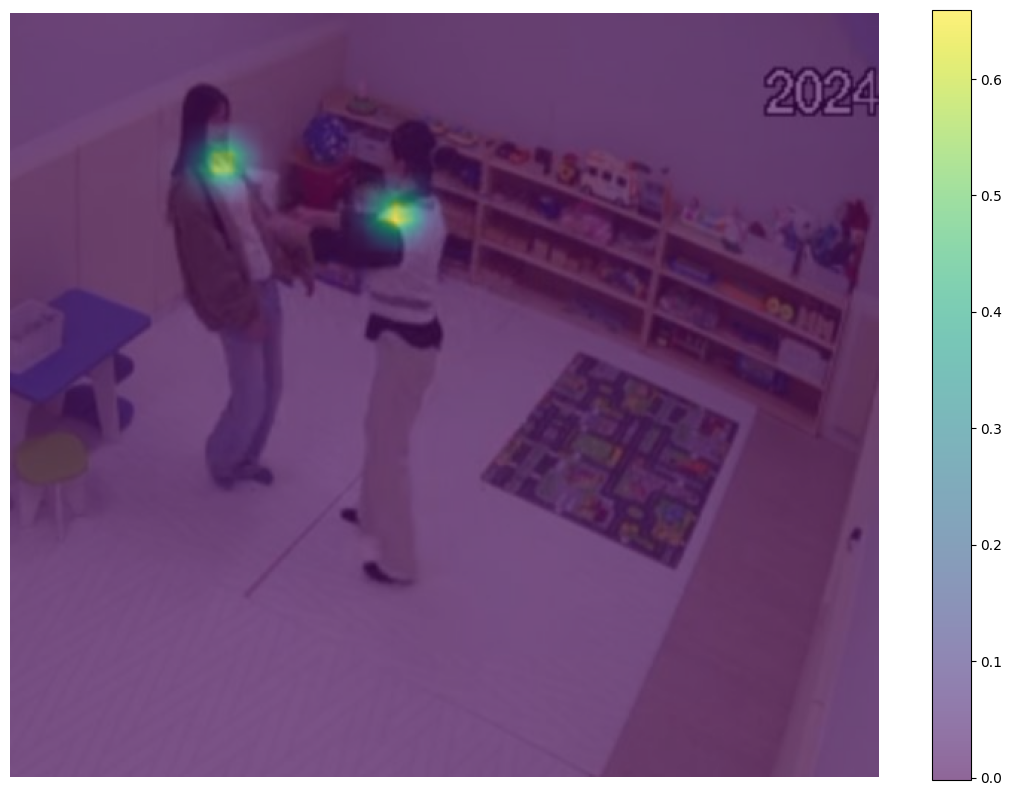

In [73]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [74]:
probMap

array([[0.00022635, 0.00022635, 0.00022635, ..., 0.00015407, 0.00015407,
        0.00015407],
       [0.00022635, 0.00022635, 0.00022635, ..., 0.00015407, 0.00015407,
        0.00015407],
       [0.00022635, 0.00022635, 0.00022635, ..., 0.00015407, 0.00015407,
        0.00015407],
       ...,
       [0.00041253, 0.00041253, 0.00041253, ..., 0.00017197, 0.00017197,
        0.00017197],
       [0.00041253, 0.00041253, 0.00041253, ..., 0.00017197, 0.00017197,
        0.00017197],
       [0.00041253, 0.00041253, 0.00041253, ..., 0.00017197, 0.00017197,
        0.00017197]], dtype=float32)

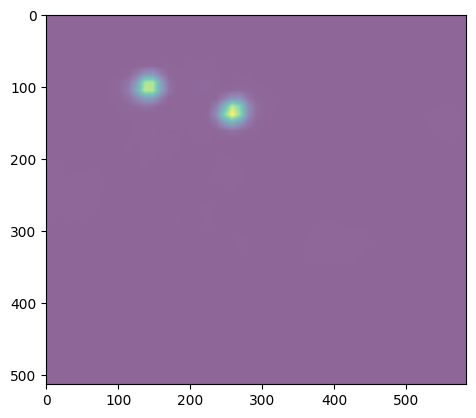

In [75]:
probMap.shape
plt.imshow(probMap, alpha=0.6)

In [76]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    # _, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [77]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
    # plt.figure()
    # plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(248, 96, 0.111223996), (138, 72, 0.6405099)]
Keypoints - Neck : [(269, 129, 0.71589744), (136, 105, 0.6747273)]
Keypoints - R-Sho : [(280, 129, 0.66123337), (126, 106, 0.71828383)]
Keypoints - R-Elb : [(127, 161, 0.6183271), (237, 139, 0.27017877)]
Keypoints - R-Wr : [(149, 196, 0.6911767), (214, 139, 0.24318653)]
Keypoints - L-Sho : [(259, 138, 0.6501404), (139, 104, 0.5482672)]
Keypoints - L-Elb : [(247, 151, 0.50004196), (159, 139, 0.17809002)]
Keypoints - L-Wr : [(205, 139, 0.40855435)]
Keypoints - R-Hip : [(269, 217, 0.48040977), (148, 185, 0.62391156)]
Keypoints - R-Knee : [(248, 284, 0.412734), (158, 251, 0.6185169)]
Keypoints - R-Ank : [(236, 330, 0.2379509), (138, 296, 0.4962662)]
Keypoints - L-Hip : [(258, 217, 0.59131134), (170, 184, 0.5836353)]
Keypoints - L-Knee : [(257, 284, 0.42551592), (170, 250, 0.5886979)]
Keypoints - L-Ank : [(259, 362, 0.33909035), (159, 296, 0.48784038)]
Keypoints - R-Eye : [(137, 72, 0.65242505)]
Keypoints - L-Eye : [(248, 95,

In [7]:
import cv2
import time
import numpy as np

protoFile = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

nPoints = 18
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]

colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

# Open video file
video_file = r'E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\dataset\trim_combined_video\hugging\hugging_30.mp4'
cap = cv2.VideoCapture(video_file)

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


def getKeypoints(probMap, threshold=0.1):
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        if maxVal > threshold:
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))
    return keypoints


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (inWidth, inHeight))


    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(resized_frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1
    
    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1
        detected_keypoints.append(keypoints_with_id)
        
    # Visualize keypoints on the frame
        for keypoints in detected_keypoints:
            print("Keypoints - {}: {}".format(keypointsMapping[i], keypoints))
            for keypoint in keypoints:
                x, y, conf, _ = keypoint  # Unpack the values
                if conf > threshold:
                    cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), -1, cv2.LINE_AA)
    
    # Draw skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        if detected_keypoints[partA] and detected_keypoints[partB]:
            cv2.line(frame, tuple(detected_keypoints[partA][0][:2]), tuple(detected_keypoints[partB][0][:2]), colors[i], 2, cv2.LINE_AA)

    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Keypoints - Nose: [(918, 552, 0.85568136, 0)]
Keypoints - Neck: [(918, 552, 0.85568136, 0)]
Keypoints - Neck: [(989, 668, 0.7554794, 1), (849, 599, 0.74367285, 2)]
Keypoints - Neck: [(918, 552, 0.85568136, 0)]
Keypoints - Neck: [(989, 668, 0.7554794, 1), (849, 599, 0.74367285, 2)]
Keypoints - Neck: [(1012, 646, 0.6782273, 3), (826, 622, 0.80873394, 4)]
Keypoints - Neck: [(918, 552, 0.85568136, 0)]
Keypoints - Neck: [(989, 668, 0.7554794, 1), (849, 599, 0.74367285, 2)]
Keypoints - Neck: [(1012, 646, 0.6782273, 3), (826, 622, 0.80873394, 4)]
Keypoints - Neck: [(847, 715, 0.6384069, 5), (1034, 622, 0.21910354, 6)]
Keypoints - Neck: [(918, 552, 0.85568136, 0)]
Keypoints - Neck: [(989, 668, 0.7554794, 1), (849, 599, 0.74367285, 2)]
Keypoints - Neck: [(1012, 646, 0.6782273, 3), (826, 622, 0.80873394, 4)]
Keypoints - Neck: [(847, 715, 0.6384069, 5), (1034, 622, 0.21910354, 6)]
Keypoints - Neck: [(873, 740, 0.5026493, 7), (1034, 621, 0.10790892, 8)]
Keypoints - Neck: [(918, 552, 0.85568136, 0)

In [78]:
print(detected_keypoints)

[[(248, 96, 0.111223996, 0), (138, 72, 0.6405099, 1)], [(269, 129, 0.71589744, 2), (136, 105, 0.6747273, 3)], [(280, 129, 0.66123337, 4), (126, 106, 0.71828383, 5)], [(127, 161, 0.6183271, 6), (237, 139, 0.27017877, 7)], [(149, 196, 0.6911767, 8), (214, 139, 0.24318653, 9)], [(259, 138, 0.6501404, 10), (139, 104, 0.5482672, 11)], [(247, 151, 0.50004196, 12), (159, 139, 0.17809002, 13)], [(205, 139, 0.40855435, 14)], [(269, 217, 0.48040977, 15), (148, 185, 0.62391156, 16)], [(248, 284, 0.412734, 17), (158, 251, 0.6185169, 18)], [(236, 330, 0.2379509, 19), (138, 296, 0.4962662, 20)], [(258, 217, 0.59131134, 21), (170, 184, 0.5836353, 22)], [(257, 284, 0.42551592, 23), (170, 250, 0.5886979, 24)], [(259, 362, 0.33909035, 25), (159, 296, 0.48784038, 26)], [(137, 72, 0.65242505, 27)], [(248, 95, 0.20968017, 28), (139, 71, 0.2924282, 29)], [(126, 72, 0.6255858, 30)], [(258, 96, 0.7294006, 31)]]


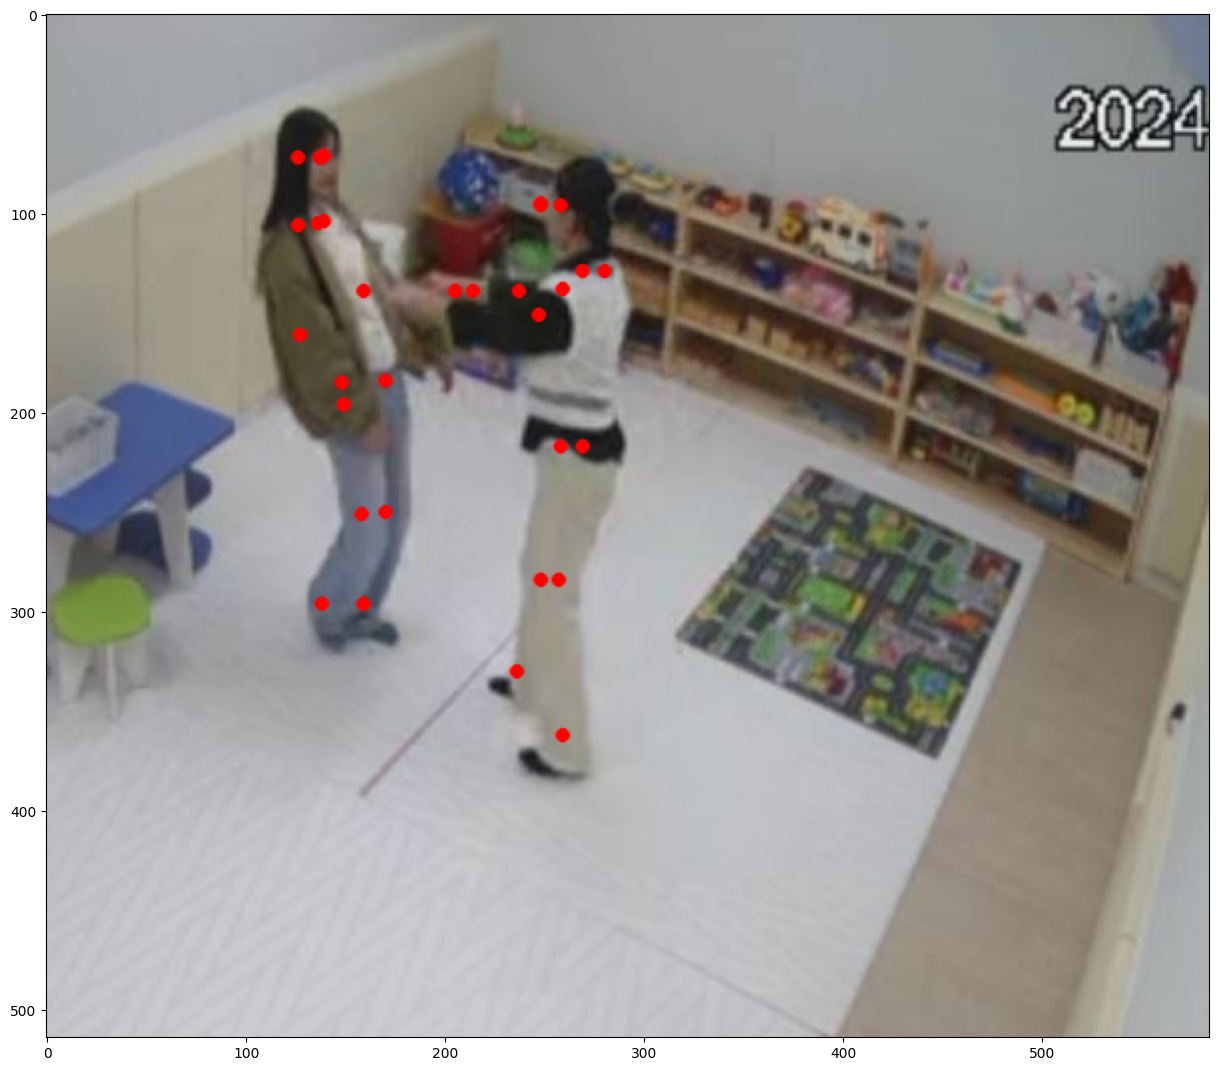

In [79]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

Finding valid joint-pairs

In [80]:
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # all POSE_PAIR
    for k in range(len(mapIdx)):
        # paf for one joint A and the other joint B of the limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Both keypoint candidates in limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # Only when joint keypoint is detected
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            # Calculate the PAF for all interpolated points set between joints
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):         
                    # Calculate distance vector(d_ij) between two joints
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    # distance vector(d_ij) normalize
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Filter with threshold to check if the connection is valid  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Save Valid Connections
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # valid_pair valid_pairs - valid_pair global variable
            valid_pairs.append(valid_pair)
            
        # Keypoint is not detected
        else: 
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [81]:
valid_pairs, invalid_pairs = getValidPairs(output)


[array([[2.        , 4.        , 0.51175727],
       [3.        , 5.        , 0.69233967]]), array([[ 2.        , 10.        ,  0.47530286],
       [ 3.        , 11.        ,  0.72314511]]), array([[4.        , 7.        , 0.24238931],
       [5.        , 6.        , 0.78459156]]), array([[6.        , 8.        , 0.80956291],
       [7.        , 9.        , 0.40039418]]), array([[10.        , 12.        ,  0.67446116],
       [11.        , 13.        ,  0.18789692]]), array([[12.        , 14.        ,  0.55631246]]), array([[ 2.        , 15.        ,  0.74868329],
       [ 3.        , 16.        ,  0.8111823 ]]), array([[15.        , 17.        ,  0.4786326 ],
       [16.        , 18.        ,  0.73572065]]), array([[17.        , 19.        ,  0.44305384],
       [18.        , 20.        ,  0.60124444]]), array([[ 2.        , 21.        ,  0.75814576],
       [ 3.        , 22.        ,  0.78774646]]), array([[21.        , 23.        ,  0.71099362],
       [22.        , 24.        ,  0.

Assemble Person-wise Keypoints

In [82]:
# for each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs): 
    #Create an empty list to store keypoints for each person
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])
            #For each valid_pair, make sure partA is in personwiseKeypoints
            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break
                # If there is partA, add partB to personwiseKeypoints as well
                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # If Mandyak partA is not on all lists, it means a new person's part that is not on the list
                elif not found and k < 17:
                    # Create and add partA-partB in one row
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # Add keypoint_scores and paf_scores for each keypoint as well
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [83]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

In [84]:
print(personwiseKeypoints)

[[ 0.          2.          4.          7.          9.         10.
  12.         14.         15.         17.         19.         21.
  23.         25.         -1.         -1.         -1.         -1.
  12.71880983]
 [ 1.          3.          5.          6.          8.         11.
  13.         -1.         16.         18.         20.         22.
  24.         26.         27.         29.         30.         -1.
  18.43840827]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         28.         -1.         31.
   1.12528188]]


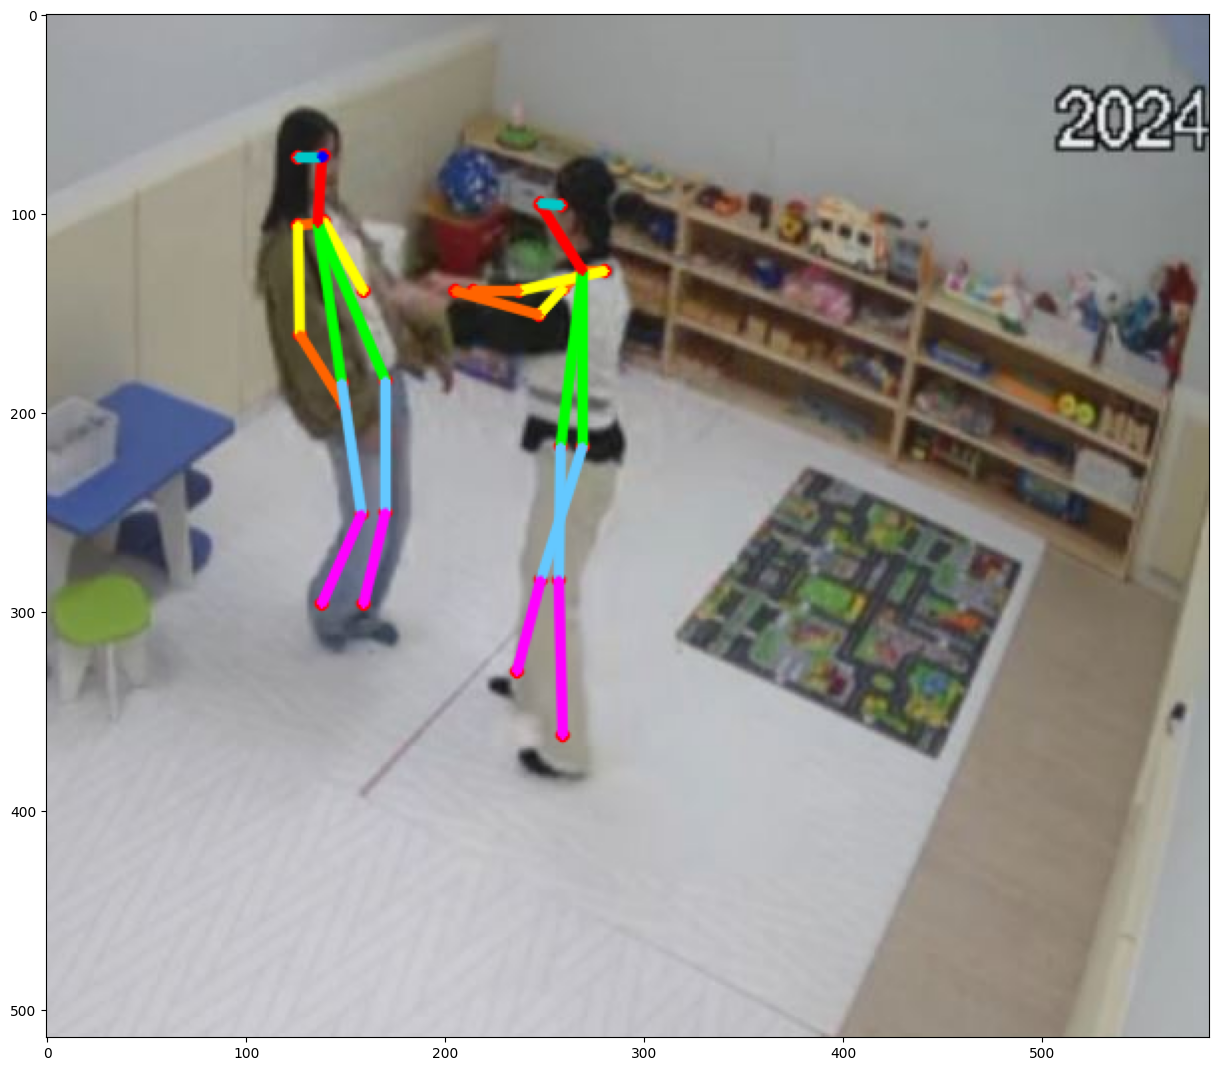

In [85]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

keypoint on the video

In [42]:
import cv2
import numpy as np

In [43]:
protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

In [44]:
nPoints = 18
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

In [45]:
POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

In [46]:
# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [47]:
# Define a function to detect keypoints in a frame
def detect_keypoints(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(nPoints):
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints


In [48]:
# Open the video file
video_path = r'E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\dataset\train\S001C001P001R001A050_rgb.avi' 
cap = cv2.VideoCapture(video_path)

In [49]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints = detect_keypoints(frame)

    # Draw keypoints on the frame
    frameClone = frame.copy()
    for i in range(nPoints):
        for j in range(len(keypoints[i])):
            cv2.circle(frameClone, keypoints[i][j][0:2], 3, [0, 0, 255], -1, cv2.LINE_AA)

    cv2.imshow('Keypoints Detection', frameClone)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

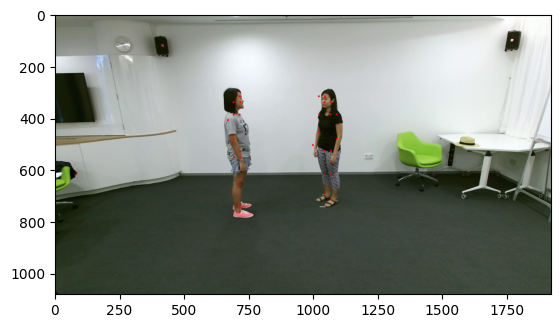

In [50]:
# Display the last frame with detected keypoints
plt.imshow(frameClone[:,:,[2,1,0]])
plt.show()

In [51]:
import cv2
import numpy as np

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

nPoints = 18
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Define a function to detect keypoints in a frame
def detect_keypoints(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(nPoints):
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints

# Open the video file
video_path = r'E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\dataset\train\S001C001P001R001A050_rgb.avi' 
cap = cv2.VideoCapture(video_path)

interaction_threshold = 50  # Adjust as needed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints = detect_keypoints(frame)

    # Check for interaction based on proximity of keypoints
    if len(keypoints) >= 2:
        person1_keypoints = keypoints[0]
        person2_keypoints = keypoints[1]

        # Example interaction criteria: check if keypoint from person1 is close to keypoint from person2
        for kp1 in person1_keypoints:
            for kp2 in person2_keypoints:
                if np.linalg.norm(np.array(kp1[:2]) - np.array(kp2[:2])) < interaction_threshold:
                    # Interaction detected, draw indicator on the frame
                    cv2.putText(frame, 'Interaction Detected', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    break  # Break inner loop if interaction detected
            else:
                continue  # Continue outer loop if no interaction detected
            break  # Break outer loop if interaction detected

    cv2.imshow('Interaction Detection', frame)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


detect keypoint from video save to csv child and mom

In [ ]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\child_mom.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


detect keypoint from video save to csv with person to person mix interaction   *noted: not use

In [ ]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\mix_action.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\mix_interaction_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


Extract keypoint from video test2

In [ ]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\test2.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\test2_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


Extract Keypoint from testing None Interaction Class

In [ ]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\none_interaction_test.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\test3_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


Test with latest video single interaction

In [1]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\dataset\Ch4\pointing\pointing_89.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames 
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\pointing_test4_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()


Test pointing 41

In [ ]:
import cv2
import numpy as np
import pandas as pd

protoFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_deploy_linevec.prototxt"
weightsFile = r"E:\Drive D\MA-ICT Convergence\Semester 4\Human-Human-Interaction\src\utils\pose_iter_440000 (1).caffemodel"

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Function to detect keypoints in a frame
def detect_keypoints(frame, frame_number):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    for part in range(18):  # 18 keypoints in COCO model
        probMap = output[0, part, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        # Find the keypoints using Non Maximum Suppression on the Confidence Map
        keypoints = []
        mapSmooth = cv2.GaussianBlur(probMap, (3, 3), 0, 0)
        mapMask = np.uint8(mapSmooth > 0.1)
        contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            blobMask = np.zeros(mapMask.shape)
            blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
            maskedProbMap = mapSmooth * blobMask
            _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
            keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

        detected_keypoints.append(keypoints)

    return detected_keypoints, frame_number

# Open the video file
video_path = r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\dataset\Ch4\pointing\pointing_41.mp4"
cap = cv2.VideoCapture(video_path)

# List to store keypoints for all frames 
all_keypoints = []

# Read and process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints in the frame
    keypoints, frame_number = detect_keypoints(frame, frame_number)
    all_keypoints.append(keypoints)

# Convert keypoints to a flattened list of dictionaries
keypoints_flat = []
for frame_number, frame_keypoints in enumerate(all_keypoints, start=1):
    keypoints_flat_frame = []
    for keypoints in frame_keypoints:
        for point in keypoints:
            x, y, confidence = point
            keypoints_flat_frame.append({'frame_number': frame_number, 'x': x, 'y': y, 'confidence': confidence})
    keypoints_flat.extend(keypoints_flat_frame)

# Convert flattened keypoints to DataFrame and save as CSV
df = pd.DataFrame(keypoints_flat)
df.to_csv(r"E:\Drive D\MA-ICT Convergence\Thesis\Human-Human-Interaction\asset\test_video\pointing41_test5_keypoints.csv", index=False)

# Release the video capture object
cap.release()
cv2.destroyAllWindows()
